In [134]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, interpolate, optimize

# Librerías para web scraping & utils 
from bs4 import BeautifulSoup
import requests 
import re #Regex

itam = (19.344443, -99.200117)
samplesize = 150
exporting = False

sns.set()

### Experimento con el metro: 
Dados puntos geográficos "disponibles", buscamos el óptimo con base en diferentes objetivos: 
- Distancia a estaciones del metro 
- Precios

Primer objetivo: 
Minimizar distancia. Primero, un estudio

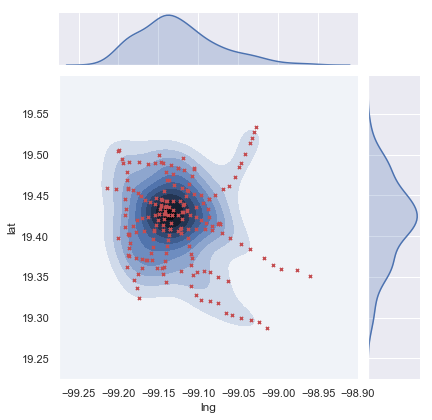

In [135]:
t_publico = pd.read_csv("data/estaciones-metro.csv", delimiter=";")
t_publico.rename(columns={"stop_lat":"lat", "stop_lon":"lng"}, inplace=True)

p = sns.jointplot(x="lng", y="lat", data=t_publico, kind="kde")
p.plot_joint(plt.scatter, c="r", s=10, marker="x")

if exporting: 
    p.savefig("figs/distplo_metro.eps", format="eps" )

In [136]:
# Creamos la función de kde gaussiana
# gaussian_kde recibe arreglos de (n x m) donde n es la cantidad de variables de la distribución
train_data = np.vstack([t_publico.lng, t_publico.lat])
kde_func = stats.gaussian_kde(train_data)

In [137]:
def c_test2(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X, Y])
    return - np.reshape(kde_func(positions).T, x.shape) + 80

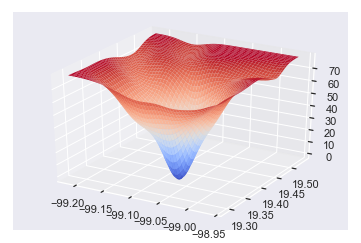

In [138]:
tx = np.linspace(t_publico.lng.min(), t_publico.lng.max(), samplesize)
ty = np.linspace(t_publico.lat.min(), t_publico.lat.max(), samplesize)
XX, YY = np.meshgrid(tx, ty)

ZZ = c_test2(XX.T, YY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(XX, YY, ZZ, cmap='coolwarm', edgecolor='none' )

if exporting: 
    fig.savefig("figs/func2_metro.eps", format="eps" )

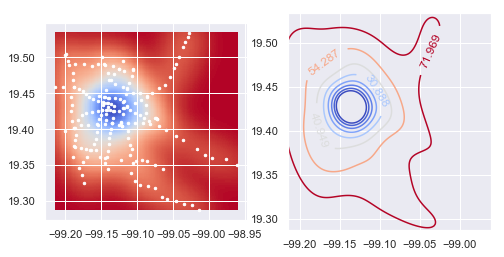

In [139]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4))
ax.imshow(np.rot90(ZZ), cmap="coolwarm",
          extent=[t_publico.lng.min(), t_publico.lng.max(), t_publico.lat.min(), t_publico.lat.max()])
ax.scatter(t_publico.lng, t_publico.lat, s=6, c="w")

cont = ax2.contour(XX, YY, ZZ.T, np.logspace(1,7), cmap="coolwarm")
ax.clabel(cont)

if exporting: 
    fig.savefig("figs/dist_func2_metro.eps", format="eps" )

Ahora, tratamos de restarle importancia a estar cerca del centroide que se forma como consecuencia de la alta concentración de estaciones en un punto

In [140]:
# Creamos la función de kde gaussiana
# gaussian_kde recibe arreglos de (n x m) donde n es la cantidad de variables de la distribución
train_data = np.vstack([t_publico.lng, t_publico.lat])
kde_func = stats.gaussian_kde(train_data)

def c_test3(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X, Y])
    res =  np.reshape(kde_func(positions).T, x.shape)
    return - ( np.log(res) / np.log(1.1) ) + 50


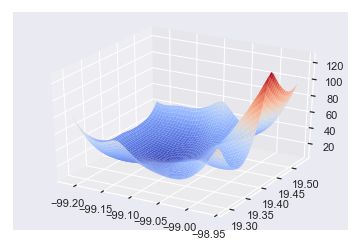

In [141]:
tx = np.linspace(t_publico.lng.min(), t_publico.lng.max(), samplesize)
ty = np.linspace(t_publico.lat.min(), t_publico.lat.max(), samplesize)
XX, YY = np.meshgrid(tx, ty)

# Nota: Quién sabe por qué hay que transponer XX y YY. Solo es asi. 
ZZ = c_test3(XX.T, YY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(XX, YY, ZZ.T, cmap='coolwarm', edgecolor='none' )

if exporting: 
    fig.savefig("figs/func3_metro.eps", format="eps" )

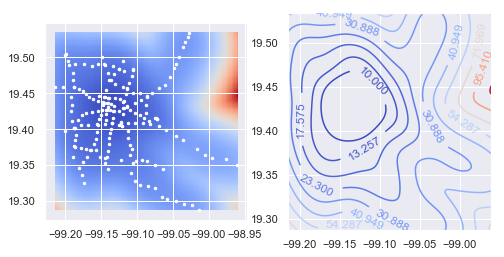

In [142]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4))
ax.imshow(np.rot90(ZZ), cmap="coolwarm",
          extent=[t_publico.lng.min(), t_publico.lng.max(), t_publico.lat.min(), t_publico.lat.max()])
ax.scatter(t_publico.lng, t_publico.lat, c="w", s=6)

cont = ax2.contour(XX, YY, ZZ.T, np.logspace(1,7), cmap="coolwarm")
ax2.clabel(cont)

if exporting: 
    fig.savefig("figs/dist_func3_metro.eps", format="eps" )

La función no es perfecta (quizán una métrica de conexidad basado en distancia a lineas de metro sea mejor)

In [143]:
C_metro = c_test3

### Metrobus
Repetimos exactamento lo mismo que se hizo con el metro

In [144]:
metrobus = pd.read_csv("data/estaciones-metrobus.csv", delimiter=";")
metrobus.rename(columns={"Latitud": "lat", "Longitud": "lng"}, inplace=True)

Estudio rápido 

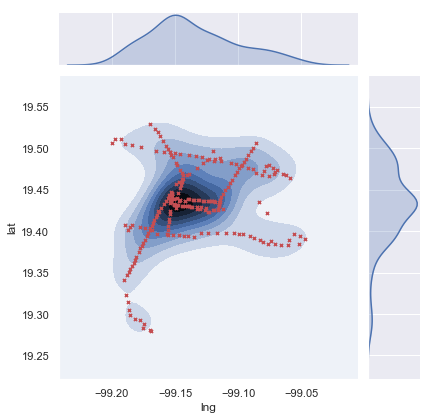

In [145]:
pp = sns.jointplot(x="lng", y="lat", data=metrobus, kind="kde")
pp.plot_joint(plt.scatter, c="r", s=10, marker="x")

if exporting: 
    pp.savefig("figs/distplo_metrobus.eps", format="eps" )

Creando la función de densidad de probabilidad para el metrobus

In [146]:
mbus_traindata = np.vstack([metrobus.lng, metrobus.lat])
mbus_kde = stats.gaussian_kde(mbus_traindata)

def mb_test(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X,Y])
    res = np.reshape(mbus_kde(positions), x.shape )
    
    return - res + 140

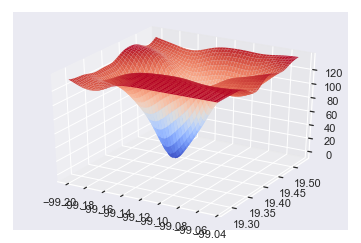

In [147]:
mx = np.linspace(metrobus.lng.min(), metrobus.lng.max(), samplesize)
my = np.linspace(metrobus.lat.min(), metrobus.lat.max(), samplesize)

xX, yY = np.meshgrid(mx, my)

#Evaluando la función
zZ = mb_test(xX.T, yY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(xX, yY, zZ.T, cmap="coolwarm", edgecolor="none")

if exporting: 
    fig.savefig("figs/func1_metrobus.eps", format="eps" )

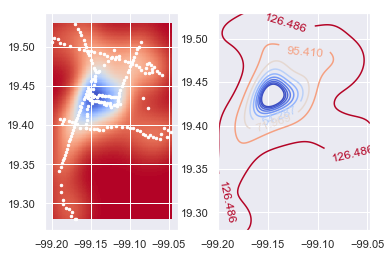

In [148]:
fig, [ax, ax2] = plt.subplots(1,2)
ax.imshow(np.rot90(zZ), cmap="coolwarm", 
         extent=[metrobus.lng.min(), metrobus.lng.max(), metrobus.lat.min(), metrobus.lat.max()])
ax.scatter(metrobus.lng, metrobus.lat,c="w", s=6)

cont = ax2.contour(xX, yY, zZ.T, np.logspace(1,7), cmap="coolwarm")
ax2.clabel(cont)

if exporting: 
    fig.savefig("figs/dist_func1_metrobus.eps", format="eps" )

De nuevo, ajustamos para no penalizar tanto a los puntos alejados del centroide

In [149]:
mbus_traindata = np.vstack([metrobus.lng, metrobus.lat])
mbus_kde = stats.gaussian_kde(mbus_traindata)

def mb_test(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X,Y])
    res = np.reshape(mbus_kde(positions).T, x.shape )
    
    return - (np.log(res) / np.log(1.2)) + 30

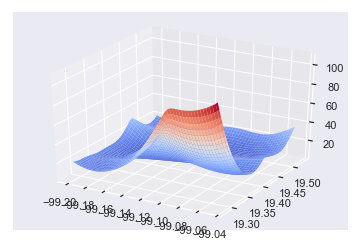

In [150]:
mx = np.linspace(metrobus.lng.min(), metrobus.lng.max(), samplesize)
my = np.linspace(metrobus.lat.min(), metrobus.lat.max(), samplesize)

xX, yY = np.meshgrid(mx, my)

#Evaluando la función
zZ = mb_test(xX.T, yY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(xX, yY, zZ.T, cmap="coolwarm", edgecolor="none")

if exporting: 
    fig.savefig("figs/func2_metrobus.eps", format="eps" )

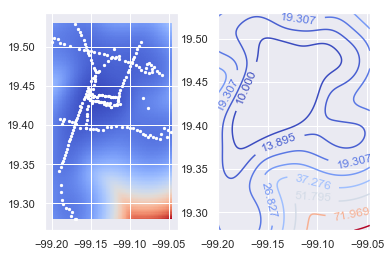

In [151]:
fig, [ax, ax2] = plt.subplots(1,2)
ax.imshow(np.rot90(zZ), cmap="coolwarm", 
         extent=[metrobus.lng.min(), metrobus.lng.max(), metrobus.lat.min(), metrobus.lat.max()])
ax.scatter(metrobus.lng, metrobus.lat, s=5, c="w")

cont = ax2.contour(xX, yY, zZ.T, np.logspace(1, 8), cmap="coolwarm")
ax2.clabel(cont, inline=1)

if exporting: 
    fig.savefig("figs/dist_func2_metrobus.eps", format="eps" )

De nuevo, la función no es perfecta, pero se asienta como la función de costos asociada al metrobus

In [152]:
C_metrobus = mb_test

Ahora visualizamos ambas funciones en acción 
$$ C_{\text{transporte}} = C_{\text{M}} + C_{\text{Mb}} $$

In [153]:
def C_transporte(X, Y): 
    return C_metro(X, Y) + C_metrobus(X, Y)

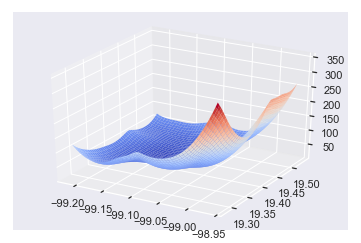

In [154]:
min_lng = min(t_publico.lng.min(), metrobus.lng.min())
min_lat = min(t_publico.lat.min(), metrobus.lat.min())
max_lng = max(t_publico.lng.max(), metrobus.lng.max())
max_lat =  max(t_publico.lat.max(), metrobus.lat.max())
ax = np.linspace(min_lng, max_lng, samplesize)
ay = np.linspace(min_lat, max_lat, samplesize)

aX, aY = np.meshgrid(ax, ay)

aZ = C_transporte(aX.T, aY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(aX, aY, aZ.T, cmap="coolwarm", edgecolor="none")

if exporting: 
    fig.savefig("figs/func_transporte.eps", format="eps" )

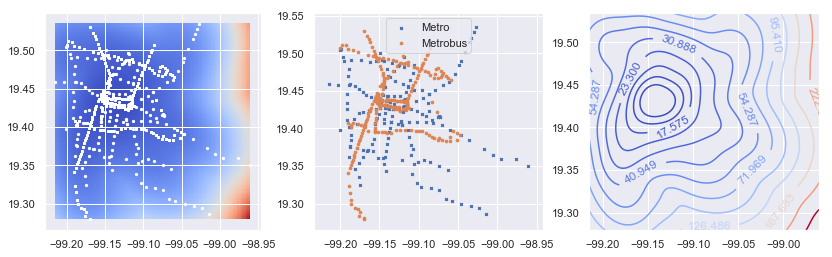

In [155]:
fig, [ax, ax2, ax3] = plt.subplots(1,3, figsize=(14,4))
ax.imshow(np.rot90(aZ), cmap="coolwarm", extent=[min_lng, max_lng, min_lat, max_lat])
ax.scatter(t_publico.lng, t_publico.lat, s=5, c="w")
ax.scatter(metrobus.lng, metrobus.lat, s=5, c="w", marker="s")

ax2.scatter(t_publico.lng, t_publico.lat, s=7, marker="x", label="Metro")
ax2.scatter(metrobus.lng, metrobus.lat, s=7, label="Metrobus")
ax2.legend()

cont = ax3.contour(aX, aY, aZ.T, np.logspace(1,7), cmap="coolwarm")
ax3.clabel(cont)

if exporting: 
    fig.savefig("figs/dist_func_transporte.eps", format="eps" )

## Segunda Parte: Web scraping

Arañamos mercado libre inmobiliario para encontrar datos de prueba. 

In [156]:
page = requests.get("https://inmuebles.mercadolibre.com.mx/oficinas/distrito-federal/")
#page = requests.get("https://inmuebles.mercadolibre.com.mx/departamentos/distrito-federal/")
soup = BeautifulSoup(page.content, "html.parser")

Hacemos un request a la página de búsqueda de propiedades de Mercado Libre con los filtos: CDMX, Oficinas

Por cada artículo listado hacemos un request de su página, y sacamos la info más básica. Nombre, precio, ubicación

**nota: La celda se tarda mucho en ejecutar. Es normal. Hace muchos requests a través de interet**

Para encontrar lat, lng hacemos parsing del texto llano del scrip. Buscamos con regex una variable 
```javascript
var dynamicMapProperties = {
					longitude: -99.2198699,
					latitude: 19.321789}
````

In [157]:
# Creando rows para crear dataFrame después 
row_list = []

items = soup.find_all("a", class_="item-link item__js-link" )
for item in items:
    link_item = item.get("href")
    
    #Obteniendo la página del resultado
    publicacion = requests.get(link_item)
    pub_soup = BeautifulSoup(publicacion.content, "html.parser")
    
    # Navegando la página del resultado para obtener precio, nobre, modo 
    nombre_p = pub_soup.find("h1", class_ = "item-title__primary").string.replace("\n","").replace("\t","").rstrip()
    precio_p = pub_soup.find("span", class_ = "price-tag-fraction").string
    precio_num = float(precio_p.replace(",",""))
    modalidad_p = pub_soup.find("p", class_="card-title").string.replace("\n","").replace("\t","").rstrip()
    
    # Encontrando lat, lng de javascript
    _lat_ = 0
    _lng_ = 0 
    for script in pub_soup.find_all("script", {"src":False}):
        if script: 
            # Regex evil 
            lng_regex = re.compile("longitude: (.*)")
            lat_regex = re.compile("latitude: (.*)")
    
            lng_str = lng_regex.search(script.text)
            lat_str = lat_regex.search(script.text)
            
            
            if lat_str and lng_str:
                # Recuperamos floats de strings de lat, lng. Más evil regex
                _lat_ = float(re.findall("[-]?\d+\.\d+", lat_str[0])[0])
                _lng_ = float(re.findall("[-]?\d+\.\d+", lng_str[0])[0])
        

    if _lat_ != 0 and _lng_ != 0:
        # Añadiendo a pandas
        row_dict = {"nombre": nombre_p, "precio": precio_num, 
                    "modalidad": modalidad_p, "lat": _lat_, "lng": _lng_, "url": link_item }
        row_list.append(row_dict)
        
    else: 
        # Preparando para pandas
        row_dict = {"nombre": nombre_p, "precio": precio_num, 
                    "modalidad": modalidad_p, "lat": np.nan, "lng": np.nan, "url": link_item }
        row_list.append(row_dict)
        
propiedades = pd.DataFrame(row_list)

In [158]:
propiedades.head()

,lat,lng,modalidad,nombre,precio,url
0,19.321789,-99.219870,Unidades disponibles,Desarrollo Torre Ho Oficinas,2598420.0,https://inmueble.mercadolibre.com.mx/MLM-68002...
1,NaN,NaN,Renta,"Tokio 714, Portales Sur, Benito Juárez",4000.0,https://inmueble.mercadolibre.com.mx/MLM-68678...
2,19.453794,-99.199779,Renta,"Ignacio Allende 21, Ampliación Torre Blanca,...",10000.0,https://inmueble.mercadolibre.com.mx/MLM-68794...
3,19.387802,-99.251068,Renta,"Bosques De Los Tamarindos 400, Bosques De Las...",10000.0,https://inmueble.mercadolibre.com.mx/MLM-68695...
4,NaN,NaN,Vende,"Lomas De Chapultepec, Miguel Hidalgo",3600000.0,https://inmueble.mercadolibre.com.mx/MLM-68892...


Ahora evaluamos añadimos el criterio de precio a la función objetivo. 

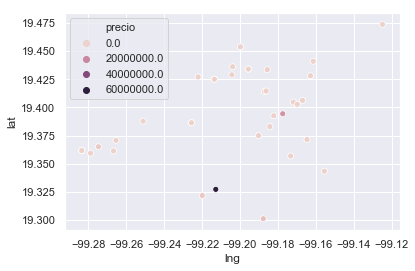

In [159]:
sns.scatterplot(x="lng", y="lat", hue="precio", data=propiedades)